# SVM (Assignment 5)

## Student: Rodolfo Lerma

In this assignment, you will implement a Support Vector Machine Classifier  from scratch and compare the results to existing sklearn algorithm. 

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# make this notebook's output stable across runs
np.random.seed(0)

## Data Exploration

In [2]:
df = pd.read_csv('data_banknote_authentication.csv', header = None)

df.columns = ['0','1','2','3','4']

In [3]:
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
df.shape

(1372, 5)

The dataset has 5 features and 1372 rows.

In [5]:
df.dtypes

0    float64
1    float64
2    float64
3    float64
4      int64
dtype: object

In [6]:
df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

There are no missing values in the dataset.


4 input features are numeric and the target variable is binary.

In [7]:
df.describe()

,0,1,2,3,4
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [8]:
features = df.columns.to_list()
features.remove('4')

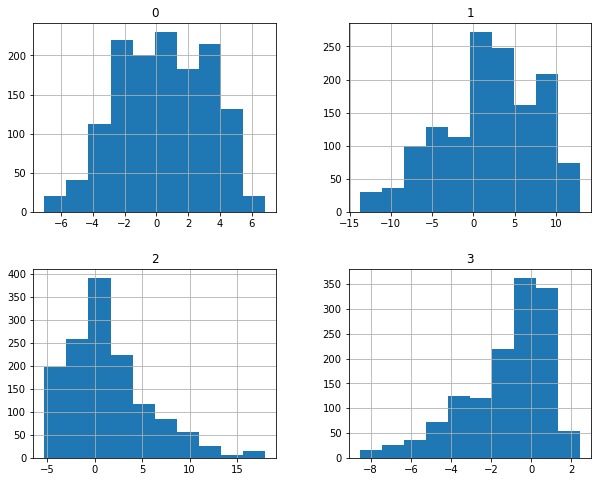

In [9]:
df[features].hist(figsize = (10,8))
plt.show()

C:\Users\rodol\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rodol\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rodol\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

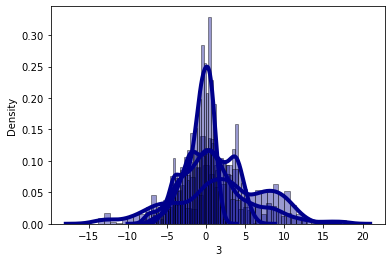

In [10]:
# Density Plot and Histogram of all arrival delays
import seaborn as sns

for i in features: 
    sns.distplot(df[i], hist=True, kde=True, 
                 bins=int(180/5), color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

<ipython-input-11-1b5e43124d83>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))


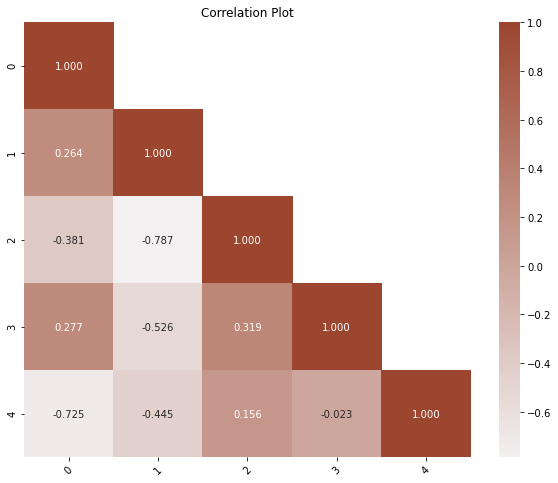

In [11]:
corr = df.corr()
hm_fig, hm_ax = plt.subplots(figsize=(10,8))
mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    fmt='.3f',
    ax=hm_ax,
    cmap=sns.light_palette('#9c462f', n_colors=300),
)
hm_ax.set_xticklabels(hm_ax.get_xticklabels(), rotation=45)
hm_ax.set_title('Correlation Plot')
hm_ax.patch.set_alpha(0);

It is possible to notice the high negative correlation between the feature `0` and the target variable.

### Target Variable

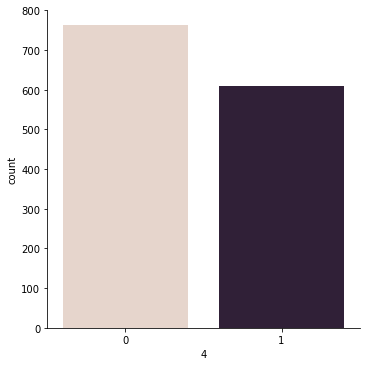

In [12]:
import seaborn as sns
sns.catplot(x='4', kind="count", palette="ch:.1", data=df)

We can see that the target feature has to variables and both are comparable in terms of their presence in the dataset. (No noticeable Class Imbalance is present in the data).

### Comparison Scatterplots

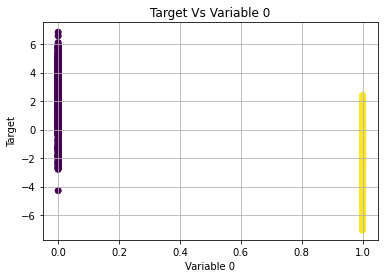

In [13]:
plt.scatter(x=df['4'], y=df['0'], c=df['4'])
plt.title("Target Vs Variable 0")
plt.xlabel("Variable 0")
plt.ylabel("Target")
plt.grid(True)
plt.show()

As it was noticed before, `Variable 0` is the one that offers the highest correlation with the `Feature` variable.

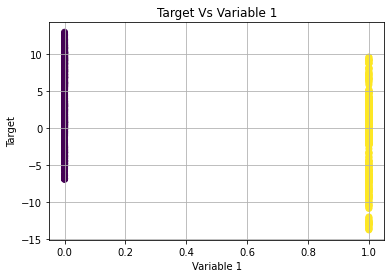

In [14]:
plt.scatter(x=df['4'], y=df['1'], c=df['4'])
plt.title("Target Vs Variable 1")
plt.xlabel("Variable 1")
plt.ylabel("Target")
plt.grid(True)
plt.show()

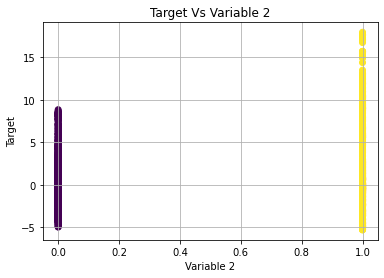

In [15]:
plt.scatter(x=df['4'], y=df['2'], c=df['4'])
plt.title("Target Vs Variable 2")
plt.xlabel("Variable 2")
plt.ylabel("Target")
plt.grid(True)
plt.show()

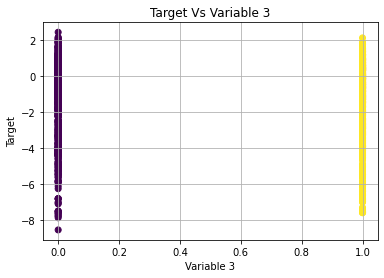

In [16]:
plt.scatter(x=df['4'], y=df['3'], c=df['4'])
plt.title("Target Vs Variable 3")
plt.xlabel("Variable 3")
plt.ylabel("Target")
plt.grid(True)
plt.show()

The `Variable 3` appers to be uncorrelated to the `Feature` Variable.

## Question 1.1: Implement the cost function cost/objective function:
<img src="https://miro.medium.com/max/688/1*JAS6rUTO7TDlrv4XZSMbsA.png" alt="drawing" width="600"/>


In [17]:
def compute_cost(W, X, Y, reg_strength=1000):
    total_num = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0
    
    #Calcule the Hinge Loss
    hinge_loss = reg_strength * np.sum(distances) / total_num
    
    #Cost Function
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    
    return cost

## Question 1.2: Write a method that calculate the cost gradient:
<img src="https://miro.medium.com/max/866/1*ww3F21VMVGp2NKhm0VTesA.png" alt="drawing" width="600"/>

In [18]:
def calculate_cost_gradient(W, X_batch, Y_batch, reg_strength=1000):
    
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))
    
    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (reg_strength * Y_batch[ind] *  X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)
    
    return dw

## Question 1.3: Write a method that performs stochastic Gradient descent as follows:
- Caluclate the gradient of cost function i.e. ∇J(w)
- Update the weights in the opposite direction to the gradient: w = w — ∝(∇J(w))
- Repeat until conversion or until 5000 epochs are reached

In [19]:
def sgd(data, outputs, learning_rate = 0.0001, max_epochs = 5000):
    
    weights = np.zeros(data.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(data, outputs)
        
        for ind, x in enumerate(X):#TO DO
            Z = Y[ind]
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent) 
            
        # convergence check on 2^nth epoch
            if epoch == 2 ** nth or epoch == max_epochs - 1:
                cost = compute_cost(weights, data, outputs)
                print("Epoch is :{} and Cost is : {}".format(epoch, cost))

                # stoppage criterion
                if abs(prev_cost - cost) < cost_threshold * prev_cost:
                    return weights

                prev_cost = cost
                nth += 1
               
    return weights

# Dataset

In [20]:
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('data_banknote_authentication.csv', header = None)

diag_map = {0: -1.0, 1: 1.0}
data[4] = data[4].map(diag_map)

Y = data.iloc[:, 4]
X = data.iloc[:, 0:4]

X_normalized = MinMaxScaler().fit_transform(X.values)
X = pd.DataFrame(X_normalized)

X.insert(loc=len(X.columns), column='intercept', value=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
Y.head()

0   -1.0
1   -1.0
2   -1.0
3   -1.0
4   -1.0
Name: 4, dtype: float64

In [22]:
X.head()

,0,1,2,3,intercept
0,0.769004,0.839643,0.106783,0.736628,1
1,0.835659,0.820982,0.121804,0.644326,1
2,0.786629,0.416648,0.310608,0.786951,1
3,0.757105,0.871699,0.054921,0.450440,1
4,0.531578,0.348662,0.424662,0.687362,1


In [23]:
X.shape

(1372, 5)

## Question 4: Train and evaluate an SVC using the banknote_authentication data

In [24]:
# train the model
print("training started...")
W = sgd(X_train.to_numpy(), y_train.to_numpy())
print("training finished.")
print("weights are: {}".format(W))

training started...
Epoch is :1 and Cost is : 949.5974818680761
Epoch is :2 and Cost is : 362.185522326451
Epoch is :4 and Cost is : 271.2316008807864
Epoch is :8 and Cost is : 196.85077013021763
Epoch is :16 and Cost is : 229.19604203752516
Epoch is :32 and Cost is : 177.7850656940311
Epoch is :64 and Cost is : 171.97162586619672
Epoch is :128 and Cost is : 221.15804648209493
Epoch is :256 and Cost is : 183.68504712612437
Epoch is :512 and Cost is : 190.01476855027343
Epoch is :1024 and Cost is : 186.41097667464885
Epoch is :2048 and Cost is : 172.29915672024993
Epoch is :4096 and Cost is : 171.8642267150484
training finished.
weights are: [-6.8414485  -5.24738112 -5.8422013   0.81046637  7.62972077]


In [25]:
# testing the model on test set
y_test_predicted = np.array([])
for i in range(X_test.shape[0]):
    yp = np.sign(np.dot(W, X_test.to_numpy()[i]))
    y_test_predicted = np.append(y_test_predicted, yp)
    
print("accuracy on test dataset: {}".format(accuracy_score(y_test.to_numpy(), y_test_predicted)))
print("recall on test dataset: {}".format(recall_score(y_test.to_numpy(), y_test_predicted)))
print("precision on test dataset: {}".format(precision_score(y_test.to_numpy(), y_test_predicted)))

accuracy on test dataset: 0.9781818181818182
recall on test dataset: 0.984251968503937
precision on test dataset: 0.9689922480620154


## [Bonus] Question 5: Train and evaluate an SKLEARN SVC model, and compare the results to your model. [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [26]:
from sklearn.svm import SVC

In [27]:
X_svm = df[features]
y_svm = df['4']

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

In [28]:
y_svm.head()

0    0
1    0
2    0
3    0
4    0
Name: 4, dtype: int64

In [29]:
X_svm.head()

,0,1,2,3
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


### Hyperparameters 

In [30]:
parameters = {"C": [0, 0.2, 0.4, 0.6, 0.8, 1.0],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "probability": [True]}

svm_base = SVC()

svm_grid = GridSearchCV(estimator = svm_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
svm_grid.fit(X_train_svm, y_train_svm)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


C:\Users\rodol\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.99269391 0.91707256
 0.99089241 0.69281902 0.99178482 0.9516764  0.99271893 0.69009174
 0.9899583  0.95989992 0.99544621 0.68461218 0.98904921 0.96353628
 0.99544621 0.67824854 0.98904921 0.96626355 0.99544621 0.67915763]
  warnings.warn(


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             verbose=2)

#### Best Hyperparameters

In [31]:
best_params = svm_grid.best_params_
best_params

{'C': 0.6, 'kernel': 'rbf', 'probability': True}

### Performance in Test Data

In [32]:
# make predictions with the trained random forest
test_svm = svm_grid.predict(X_test_svm)
test_svm_prob = svm_grid.predict_proba(X_test_svm)

In [33]:
def performance_values(X_test, y_test, trained_model):
    
    from sklearn import preprocessing, metrics
    from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
    
    y_pred = trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    probs = trained_model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.roc_auc_score(y_test, preds)
    
    return (fpr, tpr, accuracy, recall, precision, roc_auc)

In [34]:
def ROC_curve(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [35]:
fpr, tpr, svm_acc, svm_rec, svm_prec, svm_auc = performance_values(X_test_svm, y_test_svm, svm_grid)
print("Accuracy: {}".format(svm_acc))
print("Recall: {}".format(svm_rec))
print("Precision: {}".format(svm_prec))
print("AUC: {}".format(svm_auc))

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
AUC: 1.0


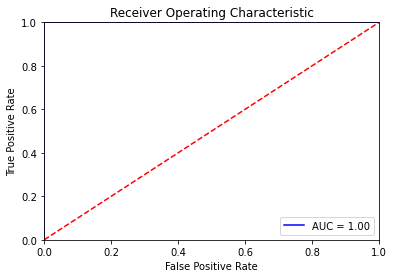

In [36]:
ROC_curve(fpr,tpr,svm_auc)

Even though this results come from Testing data (data that was not used for training) having a Performance of 100% could be an indication of Overfitting and it would be important to check with more data to experiment the potential reason for this.

### Comparison on Model with less features

There are some features that have a very low correlation value, in this section I will explore the impact on removing such variables.

The variables to be remove are `Variable 2` & `Variable 3`. Based on the correlation value (seen above) these features  does not provide much value to the prediction of the `Target` Variable.

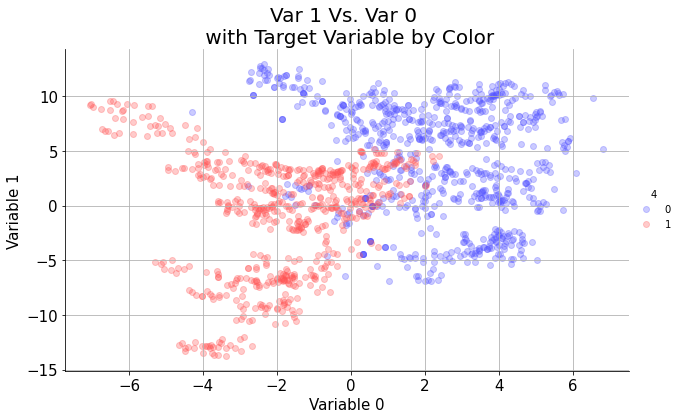

In [41]:
sns.lmplot(x = '0', 
           y = '1', 
           data = df, 
           hue = '4', 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           height=5, aspect=1.7, #This line controls the size of the plot
           fit_reg = False)

plt.xlabel('Variable 0', fontsize = 15)
plt.ylabel('Variable 1', fontsize = 15)
plt.title('Var 1 Vs. Var 0 \n with Target Variable by Color', fontsize = 20)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.grid(True)

`Variable 0` & `Variable 1` provided the highest correlation values in regards the `Target Variable` and looking at the plot it is possible to notice that both categories (`0` & `1`) have a specific sector of the plot where they concentrate. Another important note is looking at the boundary plane there is overlapping between the classes. It is possible that adding another feature could help to provide a better way to distinct among the 2 classes.

Fitting 10 folds for each of 32 candidates, totalling 320 fits


C:\Users\rodol\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.88968307 0.86869058
 0.92432027 0.65085071 0.88967473 0.86869058 0.9224854  0.63445371
 0.88967473 0.86777314 0.92613011 0.63080901 0.89059216 0.86959967
 0.92704754 0.6271643  0.89059216 0.87050876 0.92795663 0.62442035
 0.89059216 0.87233528 0.92977481 0.62624687 0.89059216 0.87417014
 0.92885738 0.62259383]
  warnings.warn(


Best Hyperparameters: {'C': 1.4, 'kernel': 'rbf', 'probability': True}
Accuracy: 0.9163636363636364
Recall: 0.8818897637795275
Precision: 0.9333333333333333
AUC: 0.9701000212811236


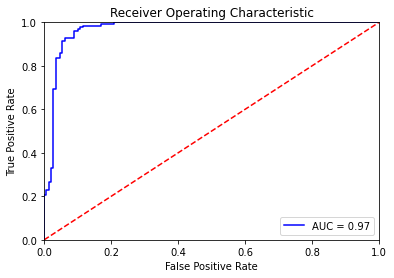

In [38]:
#Training & Testing Dataset
X_svm = df[['0','1']]
y_svm = df['4']
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

#Hyperparameters
parameters = {"C": [0, 0.2, 0.4, 0.6, 0.8, 1.2, 1.4, 2],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "probability": [True]}
svm_base = SVC()
svm_grid = GridSearchCV(estimator = svm_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)

#Training the Model
svm_grid.fit(X_train_svm, y_train_svm)

#Hyperparameters Best Parameters
best_params = svm_grid.best_params_
print("Best Hyperparameters: {}".format(best_params))

#Performance on Testing Data
fpr, tpr, svm_acc, svm_rec, svm_prec, svm_auc = performance_values(X_test_svm, y_test_svm, svm_grid)
print("Accuracy: {}".format(svm_acc))
print("Recall: {}".format(svm_rec))
print("Precision: {}".format(svm_prec))
print("AUC: {}".format(svm_auc))
ROC_curve(fpr,tpr,svm_auc)

It is possible to notice that the performance drop a little bit, but at the same time these values might be showing us that the previous model was overfitting the data.

## Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 

This assignment was very challenging as I have never worked with Support Vector Machines before much less develop the algorithm from scratch. It was very interesting to learn about this algorithm and how even though shares a lot of similarities with Logistic Regression, specially in terms of the loss function that both utilize their approach is very different in terms of the weights/importance the model assigns to each data point. This given that for Support Vector Machines the vectors/data points closer to the boundary hyperplane separating the classes, are in fact the vector/data points moving the weights on the model itself.


In this assignment as well as in practice (as seen in the literature) finding the right hyperparameters, specially in terms of `C` (Regularization Parameter) is a critical step to ensure the algorithm performs correctly. The other parameter that is important is setting the right `kernel` for the transformation trick as this will determine the algorithm’s ability to split the data correctly (minimizing as much as possible any overlapping).


Finally as we saw for this project, it might be required to test the model with new unseen data to determine if there is really a clear separation between the categories given the perfect performance score obtained by the model with the optimal hyperparameters seen above).